
Epoch 1/10


Training       : 100%|██████████| 157/157 [00:06<00:00, 24.08it/s]


Train Loss     : 2.1476
Train Accuracy : 20.26%


Testing        : 100%|██████████| 250/250 [00:03<00:00, 63.04it/s]


Test Loss      : 1.9487
Test Accuracy  : 26.18%

Epoch 2/10


Training       : 100%|██████████| 157/157 [00:06<00:00, 24.36it/s]


Train Loss     : 1.9443
Train Accuracy : 26.50%


Testing        : 100%|██████████| 250/250 [00:03<00:00, 63.25it/s]


Test Loss      : 1.8695
Test Accuracy  : 29.64%

Epoch 3/10


Training       : 100%|██████████| 157/157 [00:06<00:00, 24.27it/s]


Train Loss     : 1.8719
Train Accuracy : 28.04%


Testing        : 100%|██████████| 250/250 [00:03<00:00, 65.20it/s]


Test Loss      : 1.8181
Test Accuracy  : 31.04%

Epoch 4/10


Training       : 100%|██████████| 157/157 [00:06<00:00, 24.28it/s]


Train Loss     : 1.7977
Train Accuracy : 31.98%


Testing        : 100%|██████████| 250/250 [00:04<00:00, 62.34it/s]


Test Loss      : 1.7190
Test Accuracy  : 34.54%

Epoch 5/10


Training       : 100%|██████████| 157/157 [00:06<00:00, 24.36it/s]


Train Loss     : 1.7368
Train Accuracy : 33.84%


Testing        : 100%|██████████| 250/250 [00:03<00:00, 63.02it/s]


Test Loss      : 1.6408
Test Accuracy  : 38.29%

Epoch 6/10


Training       : 100%|██████████| 157/157 [00:06<00:00, 24.75it/s]


Train Loss     : 1.6646
Train Accuracy : 37.30%


Testing        : 100%|██████████| 250/250 [00:03<00:00, 67.24it/s]


Test Loss      : 1.5956
Test Accuracy  : 40.50%

Epoch 7/10


Training       : 100%|██████████| 157/157 [00:06<00:00, 24.95it/s]


Train Loss     : 1.6115
Train Accuracy : 40.12%


Testing        : 100%|██████████| 250/250 [00:03<00:00, 63.31it/s]


Test Loss      : 1.5469
Test Accuracy  : 42.14%

Epoch 8/10


Training       : 100%|██████████| 157/157 [00:06<00:00, 24.77it/s]


Train Loss     : 1.5690
Train Accuracy : 41.42%


Testing        : 100%|██████████| 250/250 [00:03<00:00, 65.42it/s]


Test Loss      : 1.5499
Test Accuracy  : 43.10%

Epoch 9/10


Training       : 100%|██████████| 157/157 [00:06<00:00, 24.56it/s]


Train Loss     : 1.5432
Train Accuracy : 42.82%


Testing        : 100%|██████████| 250/250 [00:03<00:00, 63.06it/s]


Test Loss      : 1.4993
Test Accuracy  : 44.77%

Epoch 10/10


Training       : 100%|██████████| 157/157 [00:06<00:00, 24.35it/s]


Train Loss     : 1.4990
Train Accuracy : 45.06%


Testing        : 100%|██████████| 250/250 [00:03<00:00, 63.89it/s]


Test Loss      : 1.5140
Test Accuracy  : 42.73%


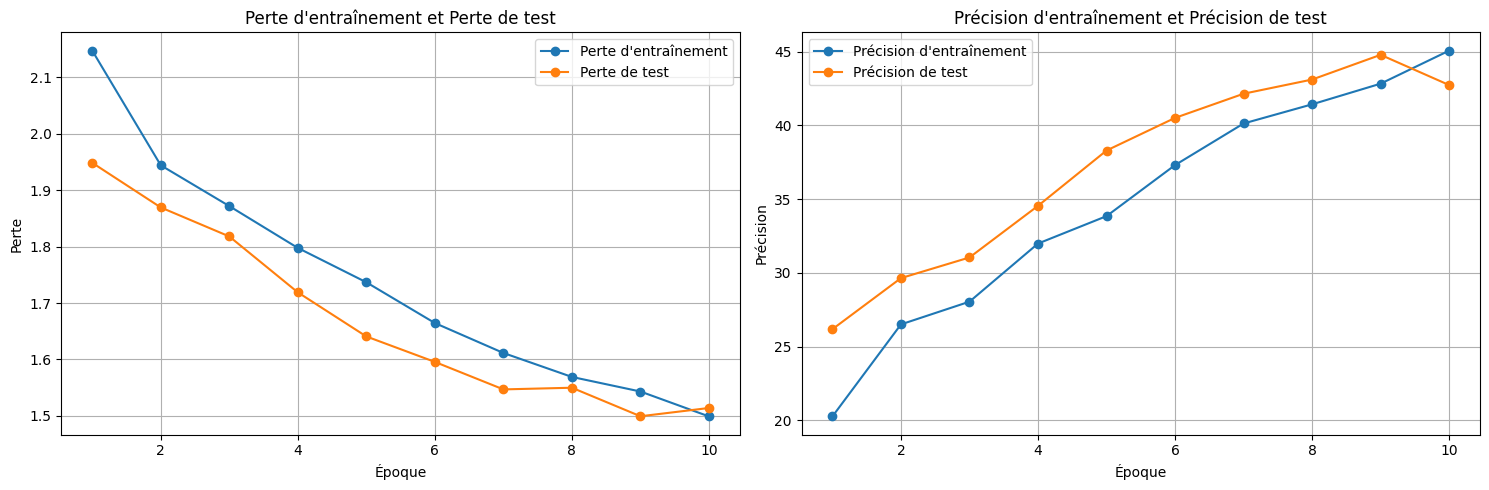

Model saved
Done


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


# Configuration des hyperparamètres
img_size = 96               # Taille des images CIFAR-10
n_channels = 3              # Nombre de canaux (3 pour CIFAR-10)
patch_size = 12             # Taille des patches, ajustée pour une meilleure performance sur CIFAR-10
d_model = 256               # Dimension de l'embedding, augmentée pour une meilleure capacité d'apprentissage
num_heads = 8               # Nombre de têtes dans l'attention multi-têtes, augmenté pour une meilleure modélisation
num_layers = 6              # Nombre de couches du Transformer, ajusté pour une meilleure profondeur
num_classes = 10           # Nombre de classes pour CIFAR-10
ff_dim = 1024              # Dimension du feedforward network, augmentée pour une meilleure performance
dropout = 0.2               # Taux de dropout, ajusté pour une meilleure généralisation

#autre parametres
lr = 1e-4                  # Taux d'apprentissage
batch_size = 32             # Taille du lot
num_epochs = 10            # Nombre d'époques



class PatchEmbedding(nn.Module):
    def __init__(self, d_model, img_size, patch_size, n_channels):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size

        # Convolution pour extraire les patches et les projeter directement dans l'espace d'embedding
        self.patch_embedding = nn.Conv2d(
            in_channels=n_channels,
            out_channels=d_model,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        N, C, H, W = x.shape

        # Passer l'image à travers la couche de patch embedding
        x = self.patch_embedding(x)           # (N, C, H, W) -> (N, D, H/patch_size, W/patch_size)
        x = x.flatten(2)                      # (N, D, H/patch_size, W/patch_size) -> (N, D, num_patches)
        x = x.transpose(1, 2)                 # (N, D, num_patches) -> (N, num_patches, D)

        return x





class ViT(nn.Module):
    def __init__(self, img_size, n_channels, patch_size, d_model, num_heads, num_layers, num_classes, ff_dim , dropout):
        super(ViT, self).__init__()

        self.patch_embedding = PatchEmbedding(d_model, img_size, patch_size, n_channels)


        # Token CLS à concaténer
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        # Embedding de position pour les patches et CLS token
        num_patches = (img_size // patch_size) ** 2
        self.position_embedding = nn.Parameter(
            torch.randn(1, num_patches + 1, d_model)
        )

        # Définition d'une couche Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,      # Dimension des embeddings
            nhead=num_heads,          # Nombre de têtes dans l'attention multi-têtes
            dim_feedforward=ff_dim,  # Dimension des couches feedforward
            dropout=dropout   ,    # Taux de dropout
            batch_first=True
            )

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)


        self.dropout = nn.Dropout(dropout)

        # Couche linéaire finale pour classification
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):

        N, C, H, W = x.shape

        # Passer l'image à travers la couche de patch embedding
        x = self.patch_embedding(x)

        # Concaténer le CLS token
        cls_tokens = self.cls_token.repeat(N, 1, 1)
        x = torch.cat((cls_tokens, x), dim=1)

        # Ajouter les embeddings de position
        x = x + self.position_embedding

        # Passer à travers le Transformer Encoder
        x = self.transformer_encoder(x)


        # Dropout
        x = self.dropout(x)

        # Prendre la sortie du token CLS
        x = x[:, 0]

        # Couche finale pour la classification
        x = self.fc(x)

        return x


# Fonction pour obtenir les DataLoaders
def get_data_loaders(batch_size=batch_size):
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(96, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    #trainset = datasets.CIFAR100(root='./data', train=True, transform=transform_train, download=True)
    #testset = datasets.CIFAR100(root='./data', train=False, transform=transform_test, download=True)

    trainset = datasets.STL10(root='./data', split='train', transform=transform_train, download=True)
    testset = datasets.STL10(root='./data', split='test', transform=transform_test, download=True)

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, testloader

# Fonction d'entraînement
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc="Training       "):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    return epoch_loss, train_accuracy


# Fonction de test
def test(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_test_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing        "):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss = running_test_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    return test_loss, test_accuracy

# Fonction principale
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    trainloader, testloader = get_data_loaders()



    # Initialisation du modèle
    model = ViT(
        img_size=img_size,
        n_channels=n_channels,
        patch_size=patch_size,
        d_model=d_model,
        num_heads=num_heads,
        num_layers=num_layers,
        num_classes=num_classes,
        ff_dim=ff_dim,
        dropout=dropout
    )

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    t_train_acc = []
    t_test_acc = []
    t_train_loss = []
    t_test_loss = []

    for epoch in range(num_epochs):

        print(f'\nEpoch {epoch+1}/{num_epochs}')
        train_loss, train_accuracy = train(model, trainloader, optimizer, criterion, device)
        print(f'Train Loss     : {train_loss:.4f}')
        print(f'Train Accuracy : {train_accuracy:.2f}%')
        test_loss, test_accuracy = test(model, testloader, criterion, device)
        print(f'Test Loss      : {test_loss:.4f}')
        print(f'Test Accuracy  : {test_accuracy:.2f}%')

        t_train_acc.append(train_accuracy)
        t_test_acc.append(test_accuracy)
        t_train_loss.append(train_loss)
        t_test_loss.append(test_loss)

    # Visualisation des pertes et des précisions
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Tracé de la perte
    ax[0].plot(range(1, num_epochs + 1), t_train_loss, label='Perte d\'entraînement', marker='o')
    ax[0].plot(range(1, num_epochs + 1), t_test_loss, label='Perte de test', marker='o')
    ax[0].set_xlabel('Époque')
    ax[0].set_ylabel('Perte')
    ax[0].set_title('Perte d\'entraînement et Perte de test')
    ax[0].legend()
    ax[0].grid(True)

    # Tracé de la précision
    ax[1].plot(range(1, num_epochs + 1), t_train_acc, label='Précision d\'entraînement', marker='o')
    ax[1].plot(range(1, num_epochs + 1), t_test_acc, label='Précision de test', marker='o')
    ax[1].set_xlabel('Époque')
    ax[1].set_ylabel('Précision')
    ax[1].set_title('Précision d\'entraînement et Précision de test')
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

    torch.save(model.state_dict(), 'model_state_dict.pth')
    torch.save(model, 'model.pth')
    print("Model saved")
    print("Done")


if __name__ == '__main__':
    main()